$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics, ConfigurationDynamics

class KoopPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q = x[:int(n/2)]
        q_d = self.xd[:int(n/2)]

        return  q - q_d

    def derivative(self, x, t):
        q_dot = x[int(n/2):]
        q_dot_d = self.xd[int(n/2):]

        return q_dot - q_dot_d

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
system = FiniteDimKoopSys(lambd, mu, c)
sys_name = 'bilinearizable_sys'

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# Collect data for learning 

In [4]:
import scipy as sc

q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_lin, B_lin, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_lin.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection

# Data collection parameters:
collect_data = True
test_frac = 0.2
val_frac = 0.2
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 10                                                      # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([1., 1., 1., 1.])                                   # State constraints, trajectory generation
xmin = -xmax
umax = np.array([10., 10.])                                         # Actuation constraint, trajectory generation
umin = -umax
x0_max = xmax/2                                                     # Initial value limits
directory = 'data/'                                           # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot

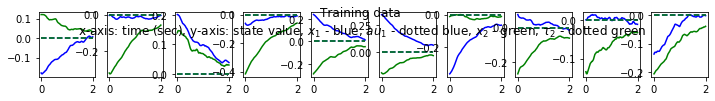

In [5]:
import matplotlib.pyplot as plt
import random as rand
from core.controllers import PDController
from koopman_core.controllers import PerturbedController, OpenLoopController
import dill

if collect_data:
    xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
    us = np.empty((n_traj_dc, n_pred_dc, m))

    plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
    for ii in range(n_traj_dc):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.zeros(n)

        output = KoopPdOutput(system, set_pt_dc, n, m)
        pd_controller = PDController(output, K_dc_p, K_dc_d)
        perturbed_pd_controller = PerturbedController(system, pd_controller, noise_var)
        xs[ii, :, :], us[ii, :, :] = system.simulate(x0, perturbed_pd_controller, t_eval)

        plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
        plt.plot(t_eval, xs[ii, :, 0], 'b', label='$x_1$')
        plt.plot(t_eval, xs[ii, :, 1], 'g', label='$x_2$')
        plt.plot(t_eval, set_pt_dc[0]*np.ones_like(xs[ii,:,0]), '--b', label='$\\tau_1$')
        plt.plot(t_eval, set_pt_dc[1]*np.ones_like(xs[ii,:,0]), '--g', label='$\\tau_2$')

    plt.suptitle(
        'Training data \nx-axis: time (sec), y-axis: state value, $x_1$ - blue, $\tau_1$ - dotted blue, $x_2$ - green, $\\tau_2$ - dotted green',
        y=0.94)
    plt.show()
    
    data_list = [xs, us, t_eval, n_traj_dc]
    outfile = open(directory + sys_name + '_data.pickle', 'wb')
    dill.dump(data_list, outfile)
    outfile.close()
else:
    infile = open(directory + sys_name + '_data.pickle', 'rb')
    xs, us, t_eval, n_traj_dc = dill.load(infile)
    infile.close()

# Tune Koopman-based model of the dynamics

### Learn Koopman DNN model

In [6]:
from koopman_core.learning import KoopDnn
from ray import tune

net_params = {}
# Model configuration parameters:
net_params['state_dim'] = n
net_params['ctrl_dim'] = m
net_params['first_obs_const'] = True
net_params['override_kinematics'] = True
net_params['dt'] = dt
net_params['data_dir'] = directory

# DNN architecture parameters:
net_params['encoder_hidden_dim'] = [20, 20]
net_params['encoder_output_dim'] = 10
net_params['epochs'] = 500
net_params['optimizer'] = 'adam'

# DNN tunable parameters:
net_params['lr'] = tune.grid_search(list(np.logspace(-5, -1, 5)))
net_params['l2_reg'] = tune.grid_search(list(np.logspace(-6, -2, 5)))
net_params['l1_reg'] = tune.grid_search(list(np.logspace(-6, -2, 5)))
net_params['batch_size'] = tune.grid_search([8, 16, 32])
net_params['lin_loss_penalty'] = tune.grid_search(list(np.linspace(1e-2, 1, 10)))
net_params['n_multistep'] = tune.grid_search([1, 5, 10, 30])
print(net_params['lr'])
print(net_params['l2_reg'])

{'grid_search': [1e-05, 0.0001, 0.001, 0.01, 0.1]}
{'grid_search': [1e-06, 1e-05, 0.0001, 0.001, 0.01]}


In [7]:
from koopman_core.dynamics import BilinearLiftedDynamics
import torch
from torch.utils.data import random_split
from ray.tune.schedulers import ASHAScheduler

model_kdnn = KoopDnn(n_traj_dc, net_params)
model_kdnn.set_datasets(xs, us, xs, us, t_eval) # TODO: Collect and store test dataset


# TODO: Do elsewhere
#        test_abs = int(len(dataset) * test_frac)
#        dataset_train, dataset_test = random_split(dataset, [len(dataset) - test_abs, test_abs])
#        model_kdnn.set_datasets(dataset_train, dataset_test)

#model_kdnn.train_model(dataset_train, dataset_val)
#model_kdnn.construct_koopman_model()

#n_tot = net_params['state_dim'] + net_params['encoder_output_dim'] + int(net_params['first_obs_const'])
#sys_kdnn = BilinearLiftedDynamics(n_tot, m, model_kdnn.A, model_kdnn.B, model_kdnn.C, model_kdnn.basis_encode, continuous_mdl=False, dt=dt)

In [ ]:
num_samples = 10
scheduler = ASHAScheduler(
        max_t=net_params['epochs'],
        grace_period=1,
        reduction_factor=2)

result = tune.run(
    model_kdnn.model_pipeline,
    config=net_params,
    metric='loss',
    mode='min',
    checkpoint_at_end=True,
    num_samples=num_samples,
    scheduler=scheduler,
)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

# TODO: Save parameter file

2021-01-19 20:06:49,420	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265


# Evaluate open-loop prediction performance

In [ ]:
# Prediction performance evaluation parameters:
folder_plots = 'figures/'                                          # Path to save plots
n_traj_ol = 50                                                     # Number of trajectories to execute, open loop

In [ ]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_koop_dnn_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.zeros(n)
    
    output = KoopPdOutput(finite_dim_koop_sys, set_pt_dc, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(finite_dim_koop_sys, pd_controller, noise_var)
    xs_ol[ii, :, :], us_test[ii, :, :] = finite_dim_koop_sys.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:], t_eval[:-1])

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T
    
    z_0_koop_dnn = sys_koop_dnn.basis(np.atleast_2d(x0)).squeeze()
    zs_koop_dnn_tmp, _ = sys_koop_dnn.simulate(z_0_koop_dnn, ol_controller_nom, t_eval[:-1])
    xs_koop_dnn_ol[ii,:,:] = np.dot(model_koop_dnn.C, zs_koop_dnn_tmp.T).T

data = [xs_bedmd_ol, xs_koop_dnn_ol]
mdl_names = ['bEDMD', 'Koop DNN']
error, mse, std = [], [], []

for ii, d in enumerate(data):
    err_tmp = xs_ol[:,:-1,:]-d
    error.append(err_tmp)
    mse.append(np.mean(np.square(error[ii])))
    std.append(np.std(error[ii]))
    
print('\nOpen loop performance statistics:')

table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data, 
               headers=['Mean squared error', 'Standard deviation']))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2
col = n/row

#Plot open loop results:
plt.figure(figsize=(figwidth,4))
axs = [plt.subplot(row,col,jj+1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)
    
    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:,jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:,jj]-err_std[:,jj], err_mean[:,jj]+err_std[:,jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_'+ str(jj+1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle=plt.suptitle('Open loop prediction performance of learned models', fontsize=fs+2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig(folder_plots + 'koop_sys_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(stitle,), bbox_inches="tight")
plt.show()